# Data Modelling

## Introduction



* This notebook will include multiple models to classify whether the tewwts describe a disaster or not
* The result from multiple model will be compared to find the best model.
* The cleaned csv files from Data Cleaning notebooks are the inputs to this notebook.

In [136]:
# Importing required libraries

import os              # To interact with OS(get directory info)
import pandas as pd    # For data manipulation
import matplotlib.pyplot as plt  # To plot ROC Curve
import sklearn.metrics as metrics  # To calculate TPR, FPR, ROC-AUC and F score
from sklearn.model_selection import train_test_split # To split train and test data
from sklearn.feature_extraction.text import TfidfVectorizer #To vectorize the text
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, )
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

## Reading cleaned CSV files 

In [137]:
df_train = pd.read_csv(os.path.join(os.path.dirname('.'), '../Data Cleaning/Clean_train_data.csv'), index_col = 0)
df_test = pd.read_csv(os.path.join(os.path.dirname('.'), '../Data Cleaning/Clean_test_data.csv'), index_col = 0)

In [138]:
 df_train

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,resident ask shelter place notify officer evac...,1
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1
4,7,NaN,NaN,get send photo ruby alaska smoke wildfire pour...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane hold bridge collapse nearby home,1
7609,10870,NaN,NaN,control wild fire california even northern par...,1
7610,10871,NaN,NaN,volcano hawaii,1
7611,10872,NaN,NaN,police investigate ebike collide car little po...,1


Making a dataframe to hold the Area under the roc score and F score
from the models

In [139]:
model_result = pd.DataFrame(columns=['Model','AUC ROC','F1'])


Splitting testing and training data


In [140]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['target'], test_size=0.3)

Method to calculate the Area under the ROC curve and F  score. Also, to plot the ROC curve.

In [141]:
def roc(pred_labels,modelname):
    
    fpr, tpr, threshold = metrics.roc_curve(y_test,pred_labels)
    auc = metrics.auc(fpr, tpr)
    f = f1_score(y_test, Log_prediction)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.suptitle(modelname, fontsize=20)
    plt.show()
    return auc, f
  
    

/Users/shashanksharma/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


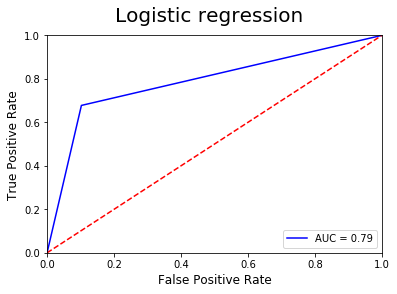

In [142]:

Log_regression = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))), ('log', LogReg())])

Log_model = Log_regression.fit(X_train, y_train)

Log_prediction = Log_model.predict(X_test)
auc,f = roc(Log_prediction,'Logistic regression')

model_result = model_result.append({'Model':'Logistic regression','AUC ROC': auc,'F1':f}, ignore_index=True)


/Users/shashanksharma/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


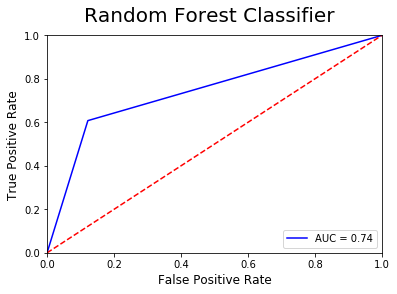

In [143]:
Random_forest = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))), ('randomforest', RandomForestClassifier())])
RF_model = Random_forest.fit(X_train, y_train)

RF_prediction = RF_model.predict(X_test)
auc,f = roc(RF_prediction,'Random Forest Classifier')

model_result = model_result.append({'Model':'Random Forest Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)

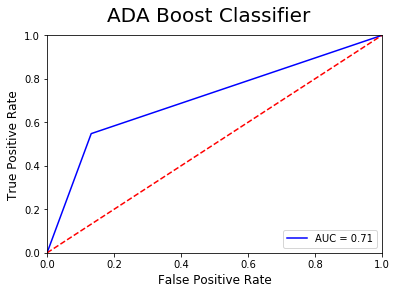

In [144]:
ada_classifier = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))), ('Ada', AdaBoostClassifier())])

ada_model = ada_classifier.fit(X_train, y_train)

ada_prediction = ada_model.predict(X_test)
auc,f = roc(ada_prediction,'ADA Boost Classifier')

model_result = model_result.append({'Model':'ADA Boost Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)

In [ ]:
et_classifier = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))), ('et', ExtraTreesClassifier())])

et_model = et_classifier.fit(X_train, y_train)

et_prediction = et_model.predict(X_test)
auc,f = roc(ada_prediction,'Extra  Classifier')

model_result = model_result.append({'Model':'ADA Boost Classifier','AUC ROC': auc,'F1':f}, ignore_index=True)
